In [ ]:
import numpy as np
import numba
from numba import cuda

In [ ]:
print(np.__version__)
print(numba.__version__)

cuda.detect()

1.22.4
0.56.4
Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-e7f6c897-c13b-75f1-f419-4ff1a658415b
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [ ]:
@cuda.jit
def add_scalars(a, b, c):
  c[0] = a + b

dev_c = cuda.device_array((1,), np.float32)

add_scalars[1, 1](2.1, 7.0, dev_c)

c = dev_c.copy_to_host()
print(f"2.0 + 7.0 = {c[0]}")

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


2.0 + 7.0 = 9.100000381469727


In [ ]:
@cuda.jit
def add_array(a, b, c):
  i = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
  if i < a.size:
    c[i] = a[i] + b[i]

N = 20
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)
dev_c = cuda.device_array_like(a)

add_array[4, 8](a, b, dev_c)

c = dev_c.copy_to_host()
print(c)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38.]


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
N = 1_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)
dev_c = cuda.device_array_like(a)

threads_per_block = 256
blocks_per_grid = (N + (threads_per_block - 1)) // threads_per_block
# Note that
#      blocks_per_grid == ceilt(N / threads_per_block)
# ensures tht blocks_per_grid * threads_per_block >= N

add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
print(c)

[0.000000e+00 2.000000e+00 4.000000e+00 ... 1.999994e+06 1.999996e+06
 1.999998e+06]


In [ ]:
@cuda.jit
def convolve2d(img, kernel, out_img):
  i, j = cuda.grid(2)
  img_rows, img_cols = img.shape
  if (i >= img_rows or j >= img_cols):
    return
  
  delta_rows = kernel.shape[0] # 2
  delta_cols = kernel.shape[1] # 2

  s = 0
  for k in range(kernel.shape[0]):
    for l in range(kernel.shape[1]):
      i_k = i - k + delta_rows
      j_l = j - l + delta_cols
      if (i_k >= 0 and i_k < img_rows and j_l >= 0 and j_l < img_cols):
        s += kernel[k, l] * img[i_k, j_l]

  out_img[i, j] = s

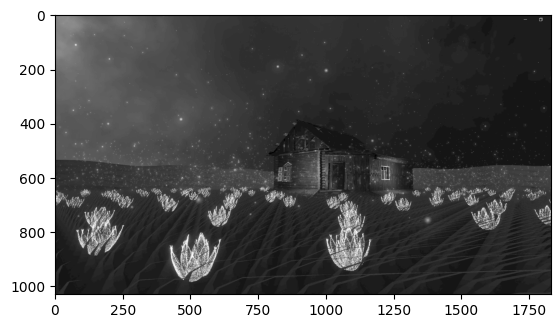

In [ ]:
from numba.cuda.stubs import blockDim
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('Interestelar_Garden.png', 0) #cv2.IMREAD_GRAYSCALE)

# Define the kernel to use for the convolution
kernel = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

# Allocate memory for the output image
out_img = np.empty_like(img)


# Copy the input data to the device
d_img = cuda.to_device(img.astype(np.float32))
d_kernel = cuda.to_device(kernel.astype(np.float32))
d_out_img = cuda.to_device(out_img.astype(np.float32))

threads_per_block = (32, 32)
blocks_per_grid = (img.shape[0] // threads_per_block[0] + 1, img.shape[1] // threads_per_block[1] + 1)

# Launch the kernel to compute the convolution
convolve2d[blocks_per_grid, threads_per_block](d_img, d_kernel, d_out_img)

# Copy the output data back to the host
out_img = d_out_img.copy_to_host()

# Display the output image
plt.imshow(img, cmap='gray')

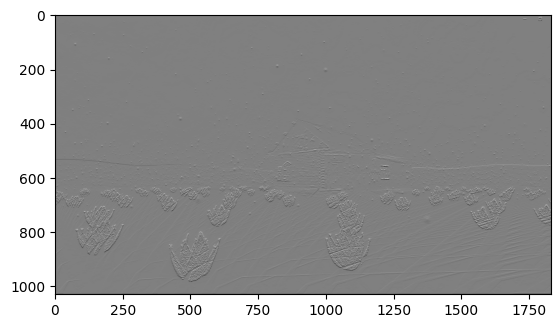

In [ ]:
plt.imshow(out_img, cmap='gray')